# Process Data

In [24]:
pip install loompy 

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.0 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# Open the loom file
loom_file = "DentateGyrus.loom"
ds = loompy.connect(loom_file)

print("Row Attributes (ds.ra):")
for key in ds.ra.keys():
    print(" -", key, "→", ds.ra[key].shape)

print("\nColumn Attributes (ds.ca):")
for key in ds.ca.keys():
    print(" -", key, "→", ds.ca[key].shape)

print("\nLayers:")
for layer in ds.layers.keys():
    print(" -", layer, "→", ds.layers[layer].shape)
    
print(ds.shape)  # (genes, cells)

# Access layers
spliced = ds.layers["spliced"][:]
unspliced = ds.layers["unspliced"][:]

# Access attributes
gene_names = ds.ra["Gene"]
tsne_coords = np.column_stack([ds.ca["TSNE1"], ds.ca["TSNE2"]])
cluster_names = ds.ca["ClusterName"]

Row Attributes (ds.ra):
 - Accession → (27998,)
 - Chromosome → (27998,)
 - End → (27998,)
 - Gene → (27998,)
 - Start → (27998,)
 - Strand → (27998,)

Column Attributes (ds.ca):
 - Age → (18213,)
 - CellID → (18213,)
 - Cell_Conc → (18213,)
 - ChipID → (18213,)
 - ClusterName → (18213,)
 - Clusters → (18213,)
 - Comments → (18213,)
 - Date_Captured → (18213,)
 - DonorID → (18213,)
 - Label → (18213,)
 - NGI_PlateWell → (18213,)
 - Num_Pooled_Animals → (18213,)
 - PCR_Cycles → (18213,)
 - Plug_Date → (18213,)
 - Project → (18213,)
 - SampleID → (18213,)
 - SampleOK → (18213,)
 - Sample_Index → (18213,)
 - Seq_Comment → (18213,)
 - Seq_Lib_Date → (18213,)
 - Seq_Lib_Ok → (18213,)
 - Serial_Number → (18213,)
 - Sex → (18213,)
 - Species → (18213,)
 - Strain → (18213,)
 - TSNE1 → (18213,)
 - TSNE2 → (18213,)
 - Target_Num_Cells → (18213,)
 - Tissue → (18213,)
 - Transcriptome → (18213,)
 - cDNA_Lib_Ok → (18213,)
 - ngperul_cDNA → (18213,)

Layers:
 -  → (27998, 18213)
 - ambiguous → (2799

# Visualize Cell Differentiation 

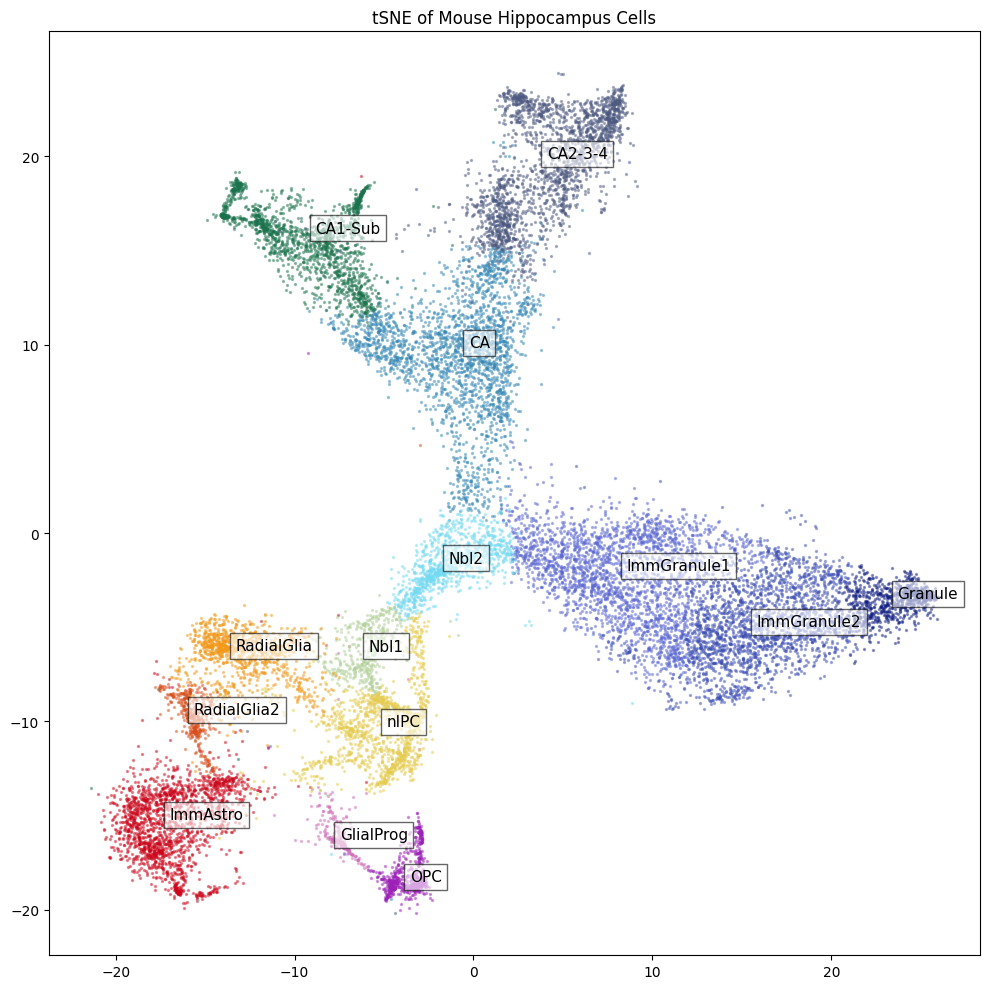

In [4]:
# Create DataFrame
df = pd.DataFrame({
    "ClusterName": cluster_names,
    "TSNE1": tsne_coords[:, 0],
    "TSNE2": tsne_coords[:, 1]
})

# Optional: Assign numeric ClusterIDs if needed
df["ClusterID"] = pd.factorize(df["ClusterName"])[0]

# Define custom cluster color mapping
colors_dict = {
    "RadialGlia": [0.95, 0.6, 0.1], "RadialGlia2": [0.85, 0.3, 0.1],
    "ImmAstro": [0.8, 0.02, 0.1], "GlialProg": [0.81, 0.43, 0.723],
    "OPC": [0.61, 0.13, 0.723], "nIPC": [0.9, 0.8 , 0.3],
    "Nbl1": [0.7, 0.82 , 0.6], "Nbl2": [0.448, 0.855, 0.951],
    "ImmGranule1": [0.35, 0.4, 0.82], "ImmGranule2": [0.23, 0.3, 0.7],
    "Granule": [0.05, 0.11, 0.51], "CA": [0.2, 0.53, 0.71],
    "CA1-Sub": [0.1, 0.45, 0.3], "CA2-3-4": [0.3, 0.35, 0.5]
}

# Plot
plt.figure(figsize=(10, 10))
for name, group in df.groupby("ClusterName"):
    plt.scatter(group["TSNE1"], group["TSNE2"], s=2, label=name,
                color=colors_dict.get(name, "gray"), alpha=0.4)

# Add cluster labels at median positions
for name, group in df.groupby("ClusterName"):
    median_pos = group[["TSNE1", "TSNE2"]].median()
    plt.text(median_pos["TSNE1"], median_pos["TSNE2"], name,
             fontsize=11, bbox={"facecolor": "w", "alpha": 0.6})

plt.title("tSNE of Mouse Hippocampus Cells")
plt.tight_layout()
plt.show()


# Filter Data

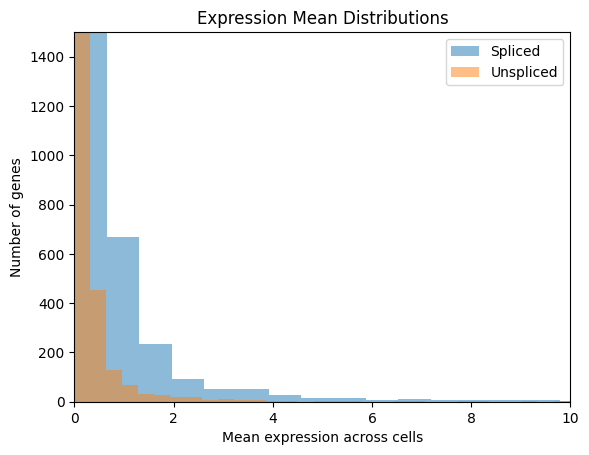

In [5]:
spliced_means = spliced.mean(axis=1)
unspliced_means = unspliced.mean(axis=1)

plt.hist(spliced_means, bins=100, alpha=0.5, label="Spliced")
plt.hist(unspliced_means, bins=100, alpha=0.5, label="Unspliced")
plt.xlabel("Mean expression across cells")
plt.ylabel("Number of genes")
plt.xlim(0,10)
plt.ylim(0,1500)
plt.legend()
plt.title("Expression Mean Distributions")
plt.show()

#based on plot, 0.1 is a reasonable threshold to weed out noise 

In [7]:
# reduce noise by filtering out low expression genes base on the graph 
threshold = 0.05
gene_mask = (unspliced.mean(axis=1) > threshold) & (spliced.mean(axis=1) > threshold)
U = unspliced[gene_mask]
S = spliced[gene_mask]

print(f"{gene_mask.sum()} genes passed the filter out of {gene_mask.shape[0]}")

3370 genes passed the filter out of 27998


# Fit RNA Velocity Model 

In [9]:
from sklearn.linear_model import LinearRegression
import numpy as np

n_genes, n_cells = U.shape
V = np.zeros((n_genes, n_cells))  # velocity matrix
coefs = np.zeros(n_genes)
intercepts = np.zeros(n_genes)

for i in range(n_genes):
    u = U[i, :].reshape(-1, 1)
    s = S[i, :]
    
    # Only fit if gene has non-zero variance (to avoid degenerate fits)
    if np.std(u) > 1e-3 and np.std(s) > 1e-3:
        model = LinearRegression().fit(u, s)
        s_pred = model.predict(u)
        V[i, :] = s - s_pred
        coefs[i] = model.coef_[0]
        intercepts[i] = model.intercept_
    else:
        V[i, :] = 0  # or np.nan if you prefer

# V now holds the velocity residuals per gene and cell

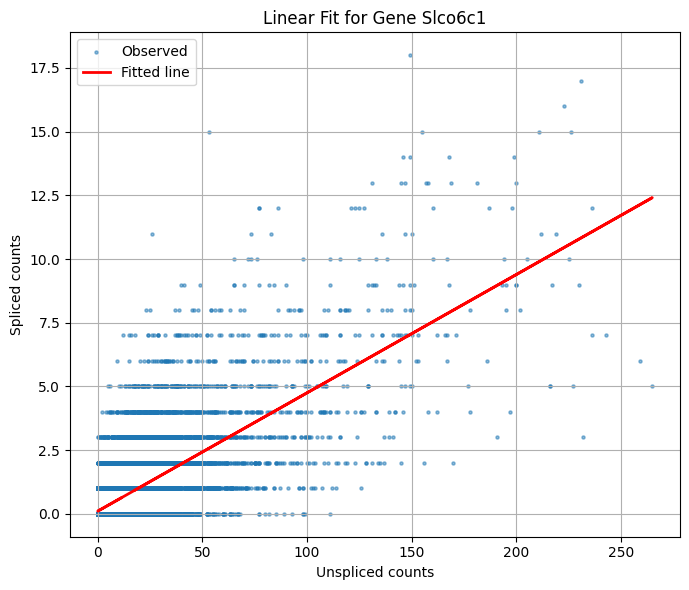

Gene: Slco6c1
Coefficient (slope): 0.0464
Intercept: 0.1040


In [10]:
gene_idx = np.argmax(np.std(U, axis=1))  # identify a high expression gene 
u = U[gene_idx, :].reshape(-1, 1)
s = S[gene_idx, :]

# Refit model for this gene
model = LinearRegression().fit(u, s)
s_pred = model.predict(u)
velocity = s - s_pred

# Plot
plt.figure(figsize=(7, 6))
plt.scatter(u, s, s=5, label="Observed", alpha=0.5)
plt.plot(u, s_pred, color="red", label="Fitted line", linewidth=2)
plt.xlabel("Unspliced counts")
plt.ylabel("Spliced counts")
plt.title(f"Linear Fit for Gene {gene_names[gene_idx]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print regression stats
print(f"Gene: {gene_names[gene_idx]}")
print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")


# Apply PCA

/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


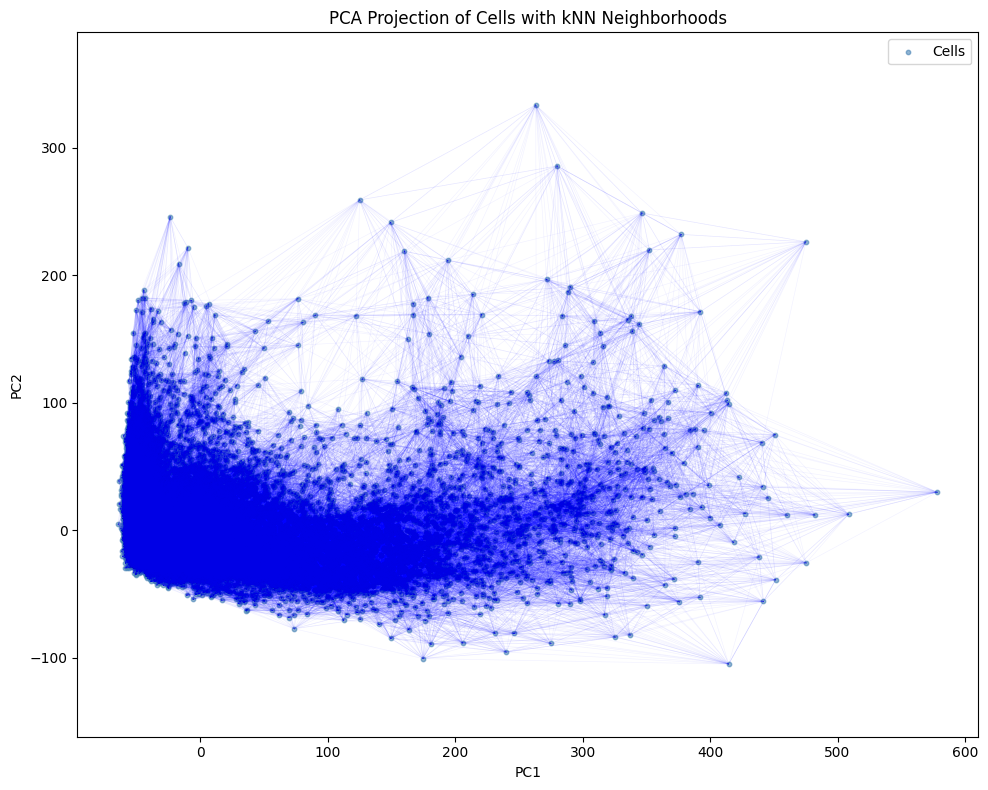

In [16]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import umap

# Step 1: PCA on spliced counts (transpose to cells × genes)
X_pca = PCA(n_components=30).fit_transform(S.T)  # (n_cells, 30)

# Step 2: Fit Nearest Neighbors on PCA-reduced data
nn = NearestNeighbors(n_neighbors=30).fit(X_pca)
neighbors = nn.kneighbors(return_distance=False)  # (n_cells, 30)

# Step 3: Pool velocity using neighbor averaging
pooled_velocity = np.zeros_like(V)  # (n_genes, n_cells)
for i in range(V.shape[1]):  # for each cell
    pooled_velocity[:, i] = V[:, neighbors[i]].mean(axis=1)

# Step 4: Project pooled velocity into 2D space
embedding = umap.UMAP().fit_transform(S.T)  # 2D embedding of cells

# Project pooled velocity into the same PCA space, then reduce to 2D
pca = PCA(n_components=2).fit(S.T)
velocity_2d = pca.components_ @ pooled_velocity  # shape: (2, n_cells)
velocity_2d = velocity_2d.T  # shape: (n_cells, 2)


plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6, color="steelblue", label="Cells")

#show neighborhoods 
for i in range(X_pca.shape[0]):
    for j in neighbors[i]:
        plt.plot([X_pca[i, 0], X_pca[j, 0]],
                 [X_pca[i, 1], X_pca[j, 1]],
                 color="blue", alpha=0.05, linewidth=0.5)

plt.title("PCA Projection of Cells with kNN Neighborhoods")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")
plt.tight_layout()
plt.legend()
plt.show()

# Visualization w/ Velocity 

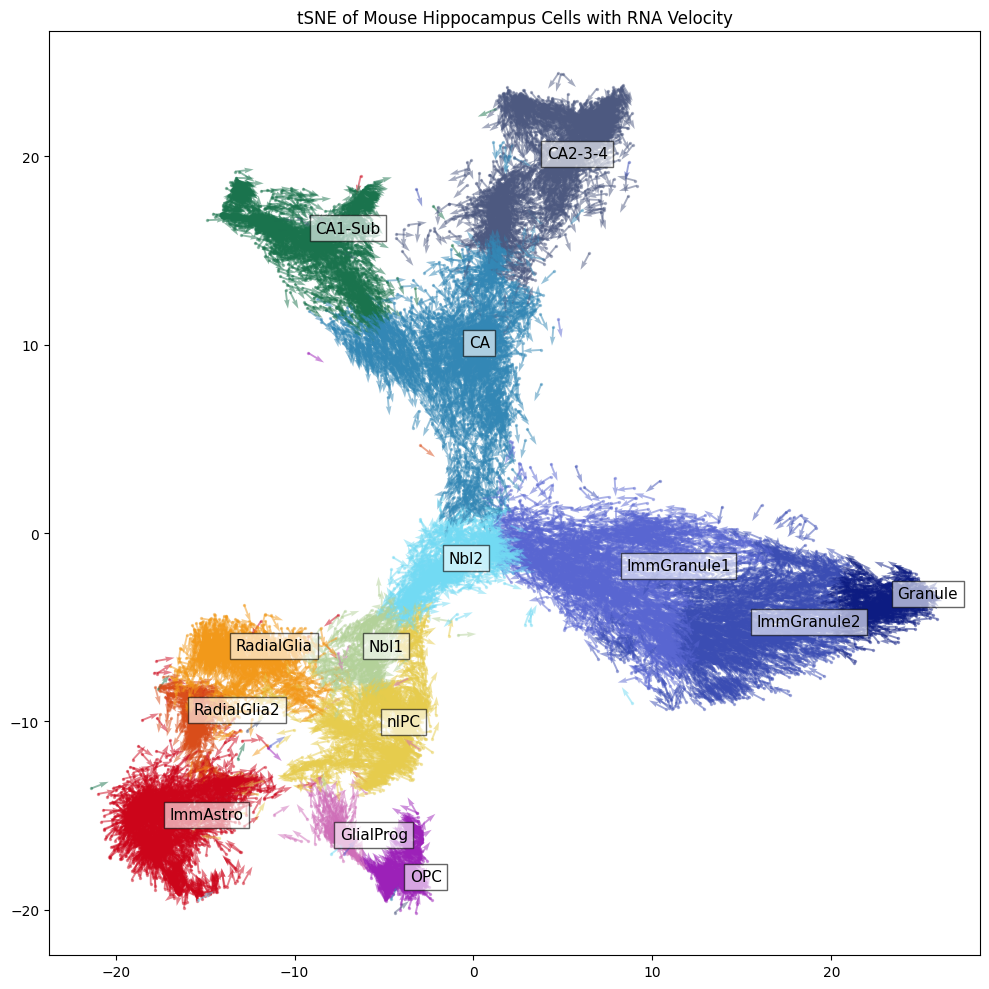

In [44]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'pooled_velocity' (RNA velocity) and 'df' (tSNE coordinates) are already defined

# === Step 1: Compute the future expression state for each cell ===
# Future state of a cell = current state + velocity
future_state = S.T + pooled_velocity.T  # shape: (n_cells, n_genes)

# === Step 2: Perform kNN on the expression space to find closest future neighbors ===
knn = NearestNeighbors(n_neighbors=30).fit(S.T)  # Fit kNN on spliced (S.T)
_, indices = knn.kneighbors(future_state)  # Find neighbors of future states in expression space

# === Step 3: Calculate displacement in tSNE space for each cell ===
tsne_coords = df[["TSNE1", "TSNE2"]].values  # Extract tSNE coordinates

# Initialize a zero matrix for storing tSNE velocity (displacement)
velocity_tsne = np.zeros_like(tsne_coords)

# For each cell, calculate the displacement to its future state
for i, neighbors in enumerate(indices):
    # Find the displacement (change) in tSNE space for all neighbors
    displacement = tsne_coords[neighbors] - tsne_coords[i]  # (n_neighbors, 2)
    
    # Average the displacements and assign it to the current cell
    velocity_tsne[i] = displacement.mean(axis=0)

# === Step 4: Normalize the velocity vectors for display ===
arrow_scale = 0.01  # Adjust scale to fit your plot
velocity_unit = velocity_tsne / (np.linalg.norm(velocity_tsne, axis=1, keepdims=True) + 1e-6)
velocity_display = velocity_unit * arrow_scale

# === Step 5: Plot the tSNE coordinates with velocity arrows ===
plt.figure(figsize=(10, 10))

# Scatter plot of tSNE cells, color-coded by cluster
for name, group in df.groupby("ClusterName"):
    plt.scatter(group["TSNE1"], group["TSNE2"], s=2, label=name,
                color=colors_dict.get(name, "gray"), alpha=0.4)

# Add cluster labels at the median positions
for name, group in df.groupby("ClusterName"):
    median_pos = group[["TSNE1", "TSNE2"]].median()
    plt.text(median_pos["TSNE1"], median_pos["TSNE2"], name,
             fontsize=11, bbox={"facecolor": "w", "alpha": 0.6})

# Get the color for each cell based on cluster
cell_colors = df["ClusterName"].map(colors_dict).fillna("gray").values

# Overlay the velocity vectors (arrows) with matching colors
plt.quiver(
    tsne_coords[:, 0], tsne_coords[:, 1], 
    velocity_display[:, 0], velocity_display[:, 1],
    color=cell_colors, scale=0.5, width=0.002, alpha=0.5
)

plt.title("tSNE of Mouse Hippocampus Cells with RNA Velocity")
plt.tight_layout()
plt.show()
